In [1]:
# import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols, glm
import scipy.stats
from statsmodels.api import families

In [2]:
# set directory
main_directory = os.getcwd().strip('notebooks')

## Property internal features analysis 

In this Section we will be examining the correlation of property internal features, such as property type, number of beds/baths/parking to the rental price of the properties. Relevant features will be selected for modelling in the next stage

In [190]:
# read in cleaned rental properties
rental_data_raw =pd.read_csv(main_directory+'data/curated/rental_properties_cleaned.csv')

In [191]:
# only want residential properties
rental_data_raw = rental_data_raw[(rental_data_raw['property_type'] != 'storage unit') &(rental_data_raw['property_type'] != 'Carspace')]

In [194]:
# drop irrelevant columns
rental_data = rental_data_raw.copy()
rental_data.drop(columns = ['Unnamed: 0.1', 'name'], inplace = True)

In [195]:
rental_data

,index,Unnamed: 0,cost_text,property_type,extra,coordinates,desc_title,desc,beds,baths,parking,under 20 (%),20 - 39 (%),40 - 59 (%),60 +(%),share_flag
6,6274,https://www.domain.com.au/14-16-bubb-street-mo...,33.000000,House,date available: available nowbond $132,"[-38.1697927, 146.2578282]",storage solutions moe - self storage containers,storage solution moe use quality shipping cont...,1,1,0,14.0,18.0,20.0,48.0,0
7,4115,https://www.domain.com.au/32-st-edmonds-rd-pra...,40.000000,Apartment / Unit / Flat,date available: available nowbond $250,"[-37.8501194, 144.9920021]",1x secured street undercover car park availabl...,"property id: 7906 (quote calling), apply here:...",0,1,1,3.0,70.0,20.0,6.0,0
8,3609,https://www.domain.com.au/car-space-6-leiceste...,46.153846,House,date available: available,"[-37.802927, 144.9606235]",car space rent!,"car space rent excellent location., steps quee...",1,1,1,2.0,93.0,4.0,1.0,0
13,5206,https://www.domain.com.au/7021y-220-spencer-st...,55.000000,Apartment / Unit / Flat,date available: available nowbond $239,"[-37.8157157, 144.9529559]",car space rent,"located 220 spencer street,. close southern cr...",1,1,1,5.0,85.0,10.0,1.0,0
16,7756,https://www.domain.com.au/8092y-33-rose-lane-m...,60.000000,Apartment / Unit / Flat,date available: available nowbond $261,"[-37.8150137, 144.9538694]",carpark available,close southern cross station. available,1,1,1,5.0,85.0,10.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,8360,https://www.domain.com.au/50-south-wharf-drive...,3750.000000,Townhouse,date available: available nowbond $16295,"[-37.8223967, 144.938237]","luxury, style space",spectacular five bedroom freehold waterfront r...,5,6,3,20.0,37.0,32.0,11.0,0
6596,11381,https://www.domain.com.au/901-902-85-market-st...,3750.000000,Apartment / Unit / Flat,date available: available,"[-37.8301164, 144.9569041]",call amy 1800 941 000 - exclusive penthouse te...,** please contact amy 1800 941 000 email admin...,3,3,1,10.0,52.0,28.0,10.0,0
6597,9692,https://www.domain.com.au/4203-35-spring-stree...,4500.000000,Apartment / Unit / Flat,date available: available nowbond $27000,"[-37.8141725, 144.9740049]",arguably melbourne's captivating penthouse,possibly prestigious cbd address heart world's...,3,2,4,11.0,32.0,31.0,26.0,0
6598,8140,https://www.domain.com.au/9-lansdowne-street-b...,5000.000000,House,"available friday, 23rd december 2022bond $2500...","[-38.372703, 144.7856897]",beautiful beach house,"phone enquiry code property : 2751, fully furn...",3,2,3,19.0,14.0,24.0,43.0,0


In [196]:
# factorize certain columns
rental_data.share_flag = rental_data.share_flag.astype('category')

In [197]:
# examine the correlation between the internal attributes of rental property; numerical

corr = rental_data.corr()
# corr.style.background_gradient(cmap='coolwarm')


Many of the features appear to be highly correlated with one another and not correlated with the response variable, we will drop all of these

In [198]:
# many of the features are correlated, we will drop correlated features that also have low correlation with response variable
rental_data.drop(columns = ['beds', 'parking', 'under 20 (%)', '20 - 39 (%)', '40 - 59 (%)', '60 +(%)'], inplace = True)

In [199]:
# correlation between categorical atts 
# function borrowed from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
from scipy.stats import chi2_contingency
import association_metrics as am
# function to calculate cramer's v
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [200]:
# define categorical variables
rental_categorical = rental_data[['share_flag', 'property_type']].astype('category')

In [201]:
# Initialize a CramersV object 
cramers_v = am.CramersV(rental_categorical)
# It will return a pairwise matrix filled with Cramer's V, where 
# columns and index are the categorical variables of the passed     # pandas.DataFrame
cfit = cramers_v.fit().round(2)
# cfit

### Modelling (reduced)

The only features that remain after selection are: property type, share flag and number of bedrooms. We will explore these possible predictors with a few statistical models in this section 

In [202]:
# generate a simple linear model
fit_OLS = ols(
   formula = "cost_text ~ share_flag + property_type + baths", data = rental_data
).fit()

In [203]:
# check the fit of the model
# fit_OLS.summary()

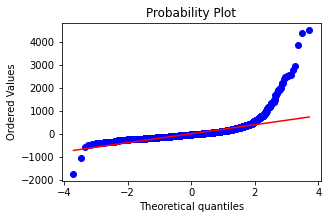

In [15]:
# plot residuals of the models
fig = plt.figure(figsize=(6,3))
headerfont = {'fontname':'Arial', 'fontsize':12}
plt.rcParams['figure.dpi'] = 360 # increase sharpness of chart
plt.gcf().subplots_adjust(bottom=0.15, left = 0.3)
ax = plt.subplot(111)
graph_DO = scipy.stats.probplot(fit_OLS.resid, plot=plt)
plt.savefig('../plots/ptobplot.png')
# plt.show()

In [16]:
# residuals show heavy tails, perhaps a negative binomial model is more suitable?
fit_NB= glm(
    formula = "cost_text ~ share_flag + property_type + baths", data = rental_data,
    family=families.NegativeBinomial()
).fit()


In [17]:
# fit_NB.summary()

In [18]:
# perform an anova on the linear regression model
anova_table = sm.stats.anova_lm(fit_OLS)

In [19]:
# from the anova table, it appears that all features selected in this section are significant
# anova_table

This section's analysis and modelling results suggest that the number of baths, property type and whether the property is shared or not is significant to the rental prices of the property. However, it appears that the variables are too simplistic on their own as predictors. Hence we will explore other external factors but retain these three features for our final modelling

## SA2 specific features analysis

In [204]:
# read in all SA2 specific features
SA2_features_raw = pd.read_csv(main_directory+'data/curated/external_features(SA2).csv')

In [205]:
# replace string values
SA2_features_raw = SA2_features_raw.replace(['np'],'0')

# drop na values
SA2_features_raw.dropna(inplace = True)

In [210]:
# make a copy to look at numerical values
SA2_features = SA2_features_raw.copy()
# drop irrelevant columns
SA2_features.drop(columns = ['pop_2021', 'Unnamed: 0','property_type','LGA code','SA2 code','SA2 name','name'], inplace = True)

In [211]:
# set(SA2_features_raw.property_type) # examine property types

In [212]:
# convert all columns to numerical 
for column in SA2_features.columns:
    # print(column)
    SA2_features[column]=SA2_features[column].astype(float)

In [213]:
# examine the correlation between the internal attributes of rental property; numerical
corr_2 = SA2_features .corr()
# corr_2.style.background_gradient(cmap='coolwarm')

Disappointingly, only mean income seem to be moderately correlated with rental prices, so we will only keep this feature for the final modelling

In [214]:
# we will now examine how the SA2 featuers are correlated when it comes to mean and median SA2 rental prices
mean_price = SA2_features_raw.groupby('SA2 name')['cost_text'].mean()
median_price = SA2_features_raw.groupby('SA2 name')['cost_text'].median()

In [215]:
# create a new dataframe to get SA2 specific features only
SA2_data = pd.DataFrame()
SA2_data['mean price'] = mean_price
SA2_data['median price']=median_price 

# iterate through dataframe and get SA2 features
for column in SA2_features_raw.iloc[[],8:]: 
    # print(column)
    # convert to float
    SA2_features_raw[column] = SA2_features_raw[column].astype(float)
    # get SA2 features
    SA2_data = SA2_data.merge(SA2_features_raw.groupby('SA2 name')[column].first(),how='left', left_index=True, right_index=True)

In [216]:
SA2_features_raw

,Unnamed: 0,index,name,LGA code,SA2 code,cost_text,property_type,SA2 name,SA2 code_y,pop_2021,Area,Children_population,Early_Working_age_population,Prime_Working_age_population,Mature_Working_age_population,Elderly_population,2021 crime rate,SA2 CODE,Median $ 2019,Mean $ 2019
0,0,3531.0,20 Adrianus Street Alfredton VIC 3350,Ballarat,201011001,460.0,House,Alfredton,201011001.0,16823.0,52.7,4075.0,2391.0,7550.0,1375.0,18255.0,0.063340,201011001.0,53932.0,63668.0
1,1,2993.0,66 Lugano Avenue Alfredton VIC 3350,Ballarat,201011001,440.0,House,Alfredton,201011001.0,16823.0,52.7,4075.0,2391.0,7550.0,1375.0,18255.0,0.063340,201011001.0,53932.0,63668.0
2,2,2924.0,15 Nyon Road Alfredton VIC 3350,Ballarat,201011001,430.0,House,Alfredton,201011001.0,16823.0,52.7,4075.0,2391.0,7550.0,1375.0,18255.0,0.063340,201011001.0,53932.0,63668.0
3,3,3589.0,33 Walters Way Alfredton VIC 3350,Ballarat,201011001,460.0,House,Alfredton,201011001.0,16823.0,52.7,4075.0,2391.0,7550.0,1375.0,18255.0,0.063340,201011001.0,53932.0,63668.0
4,4,2953.0,52 Vale Street Alfredton VIC 3350,Ballarat,201011001,440.0,House,Alfredton,201011001.0,16823.0,52.7,4075.0,2391.0,7550.0,1375.0,18255.0,0.063340,201011001.0,53932.0,63668.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6641,6641,5407.0,27 Koroit Street Warrnambool VIC 3280,Moyne,217041480,600.0,House,Warrnambool - South,217041480.0,13292.0,120.2,2064.0,1386.0,5817.0,1798.0,15519.0,0.029437,217041480.0,47242.0,58247.0
6642,6642,123.0,1 Princes Highway Warrnambool VIC 3280,Moyne,217041480,212.0,Studio,Warrnambool - South,217041480.0,13292.0,120.2,2064.0,1386.0,5817.0,1798.0,15519.0,0.029437,217041480.0,47242.0,58247.0
6643,6643,1842.0,449 Raglan Parade Warrnambool VIC 3280,Moyne,217041480,390.0,House,Warrnambool - South,217041480.0,13292.0,120.2,2064.0,1386.0,5817.0,1798.0,15519.0,0.029437,217041480.0,47242.0,58247.0
6644,6644,1562.0,238A Koroit Street Warrnambool VIC 3280,Moyne,217041480,380.0,House,Warrnambool - South,217041480.0,13292.0,120.2,2064.0,1386.0,5817.0,1798.0,15519.0,0.029437,217041480.0,47242.0,58247.0


In [217]:
# plot correlation matrixes
# examine the correlation between the internal attributes of rental property; numerical
corr_3 = SA2_data.corr()
# corr_3.style.background_gradient(cmap='coolwarm')

It looks like mean price is highly correlated with the mean SA2 rental prices, we will also potentially fit models with other moderately correlated variables

## most affordable suburb analysis

In [241]:
## concatenate income and rental info data
rental_income = SA2_features_raw.merge(rental_data_raw, on = ['name'])

In [242]:
# drop nas
rental_income.dropna(inplace = True)
rental_income.reset_index(inplace = True)

In [244]:
# get column for affordability ratio
ratios = []
# if shared, only count as one person renting it
for i in range(len(rental_income)): 
    if rental_income['share_flag'][i] == 1 or rental_income['beds'][i]==0: 
        ratios.append(rental_income['cost_text_x'][i]/((rental_income['Mean $ 2019'][i])/52))
    else:
        ratios.append(rental_income['cost_text_x'][i]/((rental_income['Mean $ 2019'][i]* rental_income['beds'][i])/52))
          
    


In [245]:
# groupby SA2 and get affordability ratio
rental_income['affordability ratio'] = ratios

In [246]:
rental_income['affordability ratio'] = rental_income['affordability ratio'].astype(float) # convert to float

In [248]:
# get average affordability ratio in each suburb
average_aff_ratios = rental_income.groupby('SA2 name')['affordability ratio'].mean()

In [249]:
average_aff_ratios.sort_values()

SA2 name
Endeavour Hills - North        0.088480
Lysterfield                    0.089196
Wattle Glen - Diamond Creek    0.091548
Wallan                         0.091598
Werribee - West                0.093264
                                 ...   
Bright - Mount Beauty          0.304937
Numurkah                       0.314701
Portarlington                  0.330129
Emerald - Cockatoo             0.343424
Flemington Racecourse          0.445338
Name: affordability ratio, Length: 314, dtype: float64

## POIs analysis

### Preliminaries

In [3]:
from numpy import arange
import matplotlib.pyplot as plt
from itertools import chain
import statsmodels.api as sm
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate

In [16]:
# Read in POI counts data
df = pd.read_csv(main_directory+'data/curated/poi_counts.csv',index_col=0)

In [17]:
#dist_df = pd.read_csv(main_directory+'data/curated/POIs/curated/distance.csv',index_col=0)
dist_df = pd.read_csv(main_directory+'data/curated/distance.csv',index_col=0)

In [80]:
# dist_df

In [18]:
# Read in category types
with open(main_directory+'/data/curated/poi_types.txt', 'r') as fp:
    ls = fp.read().splitlines()

In [82]:
# df

In [19]:
df_full = pd.concat([df, dist_df], join='inner', ignore_index=True, axis=1).drop(columns=[272])

In [20]:
columns = [['coordinates'], ls, ['cost'], ['distance', 'duration']]
columns = list(chain.from_iterable(columns))

In [21]:
df_full.set_axis(columns, axis=1, inplace=True)

C:\Users\aranw\AppData\Local\Temp\ipykernel_24980\2140439761.py:1: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_full.set_axis(columns, axis=1, inplace=True)


In [22]:
df_full.dropna(inplace=True)

In [23]:
# Reorder the columns
df_full = df_full[chain.from_iterable([['coordinates'],['distance', 'duration'], ls, ['cost']])]

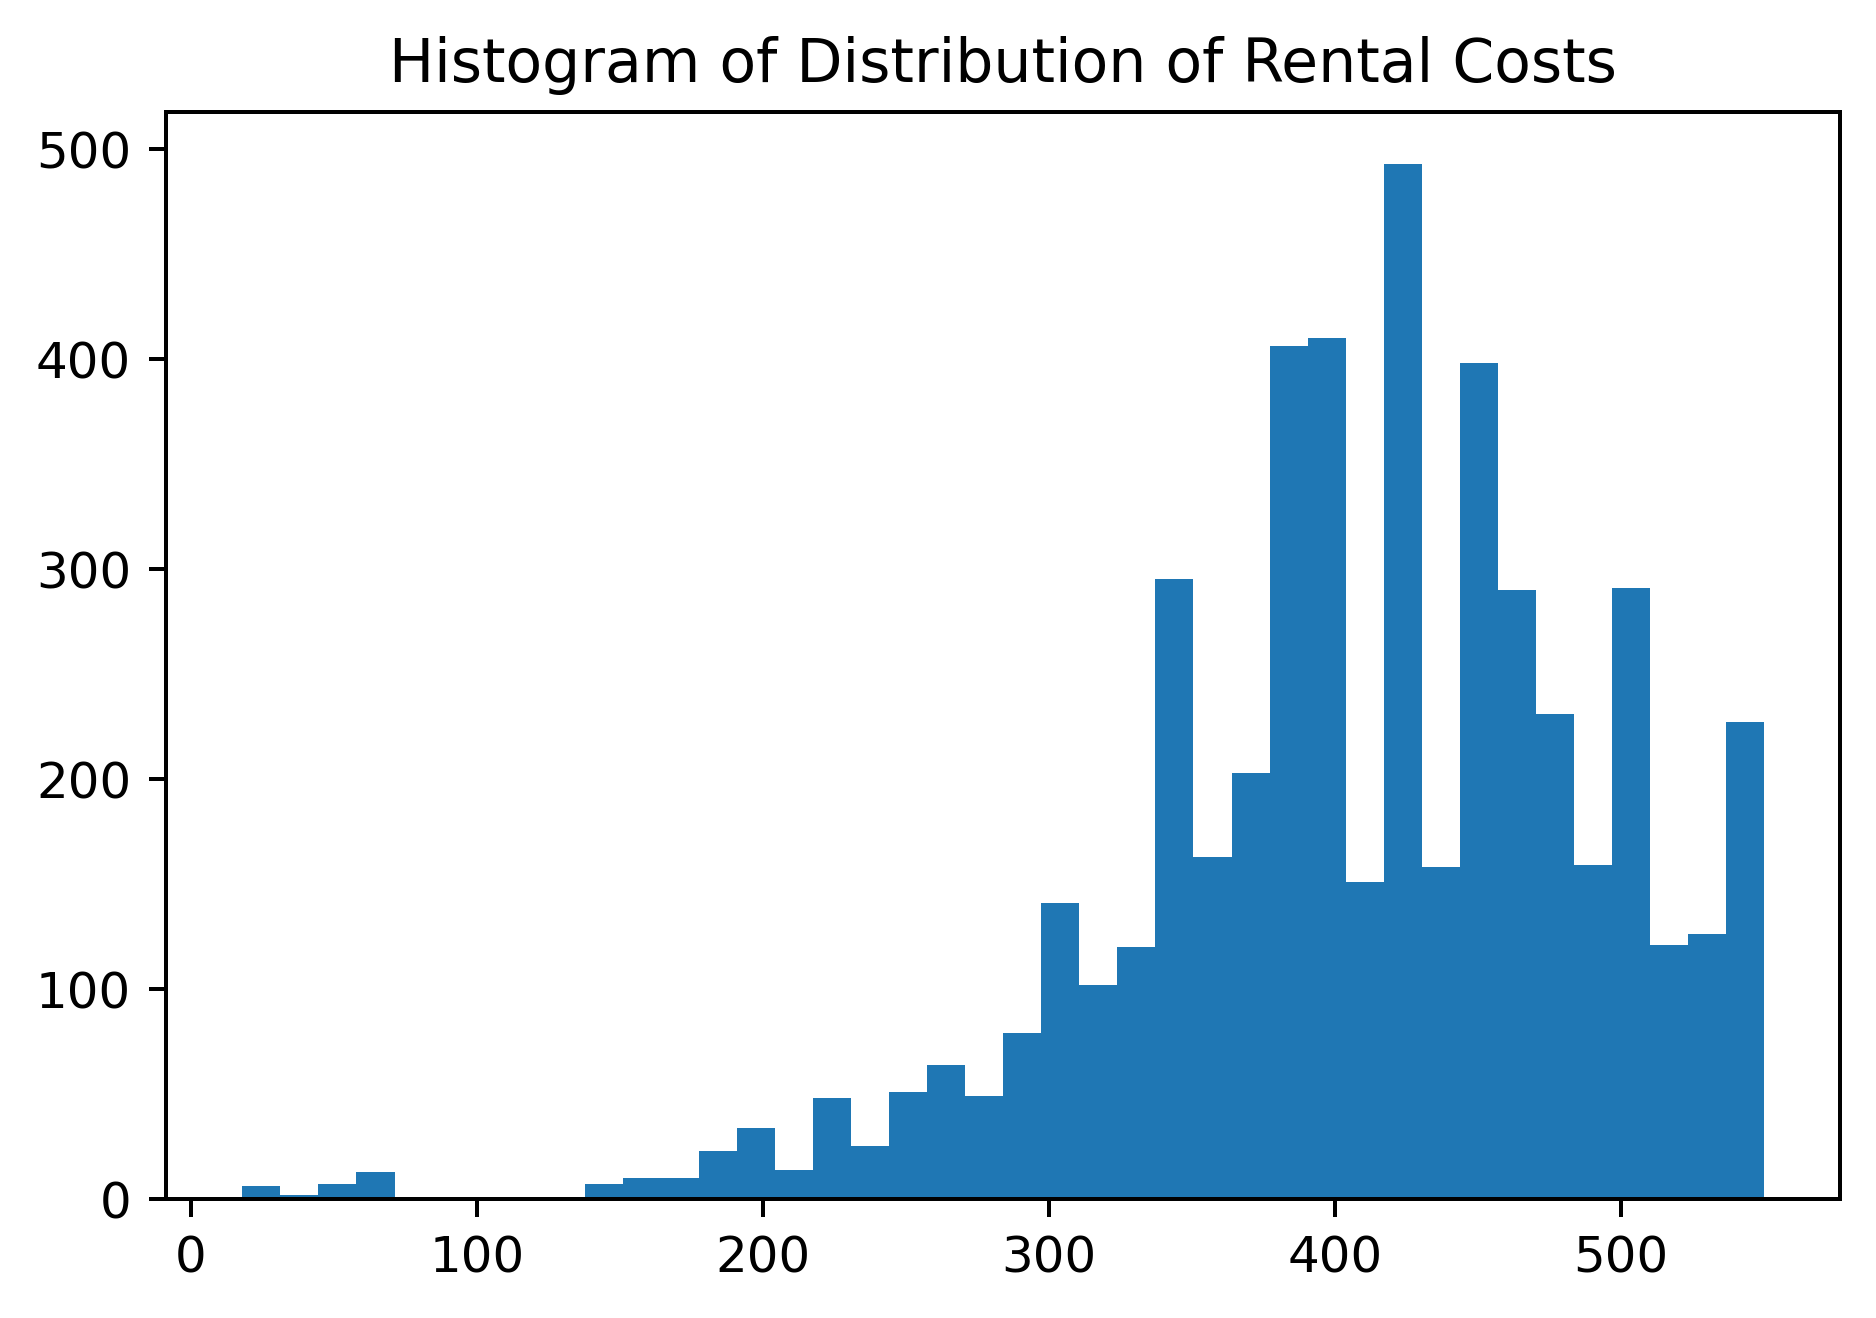

In [88]:
plt.hist(df_full['cost'], bins = 40)
plt.title('Histogram of Distribution of Rental Costs')
plt.savefig(main_directory+'models/cost_hist.png')

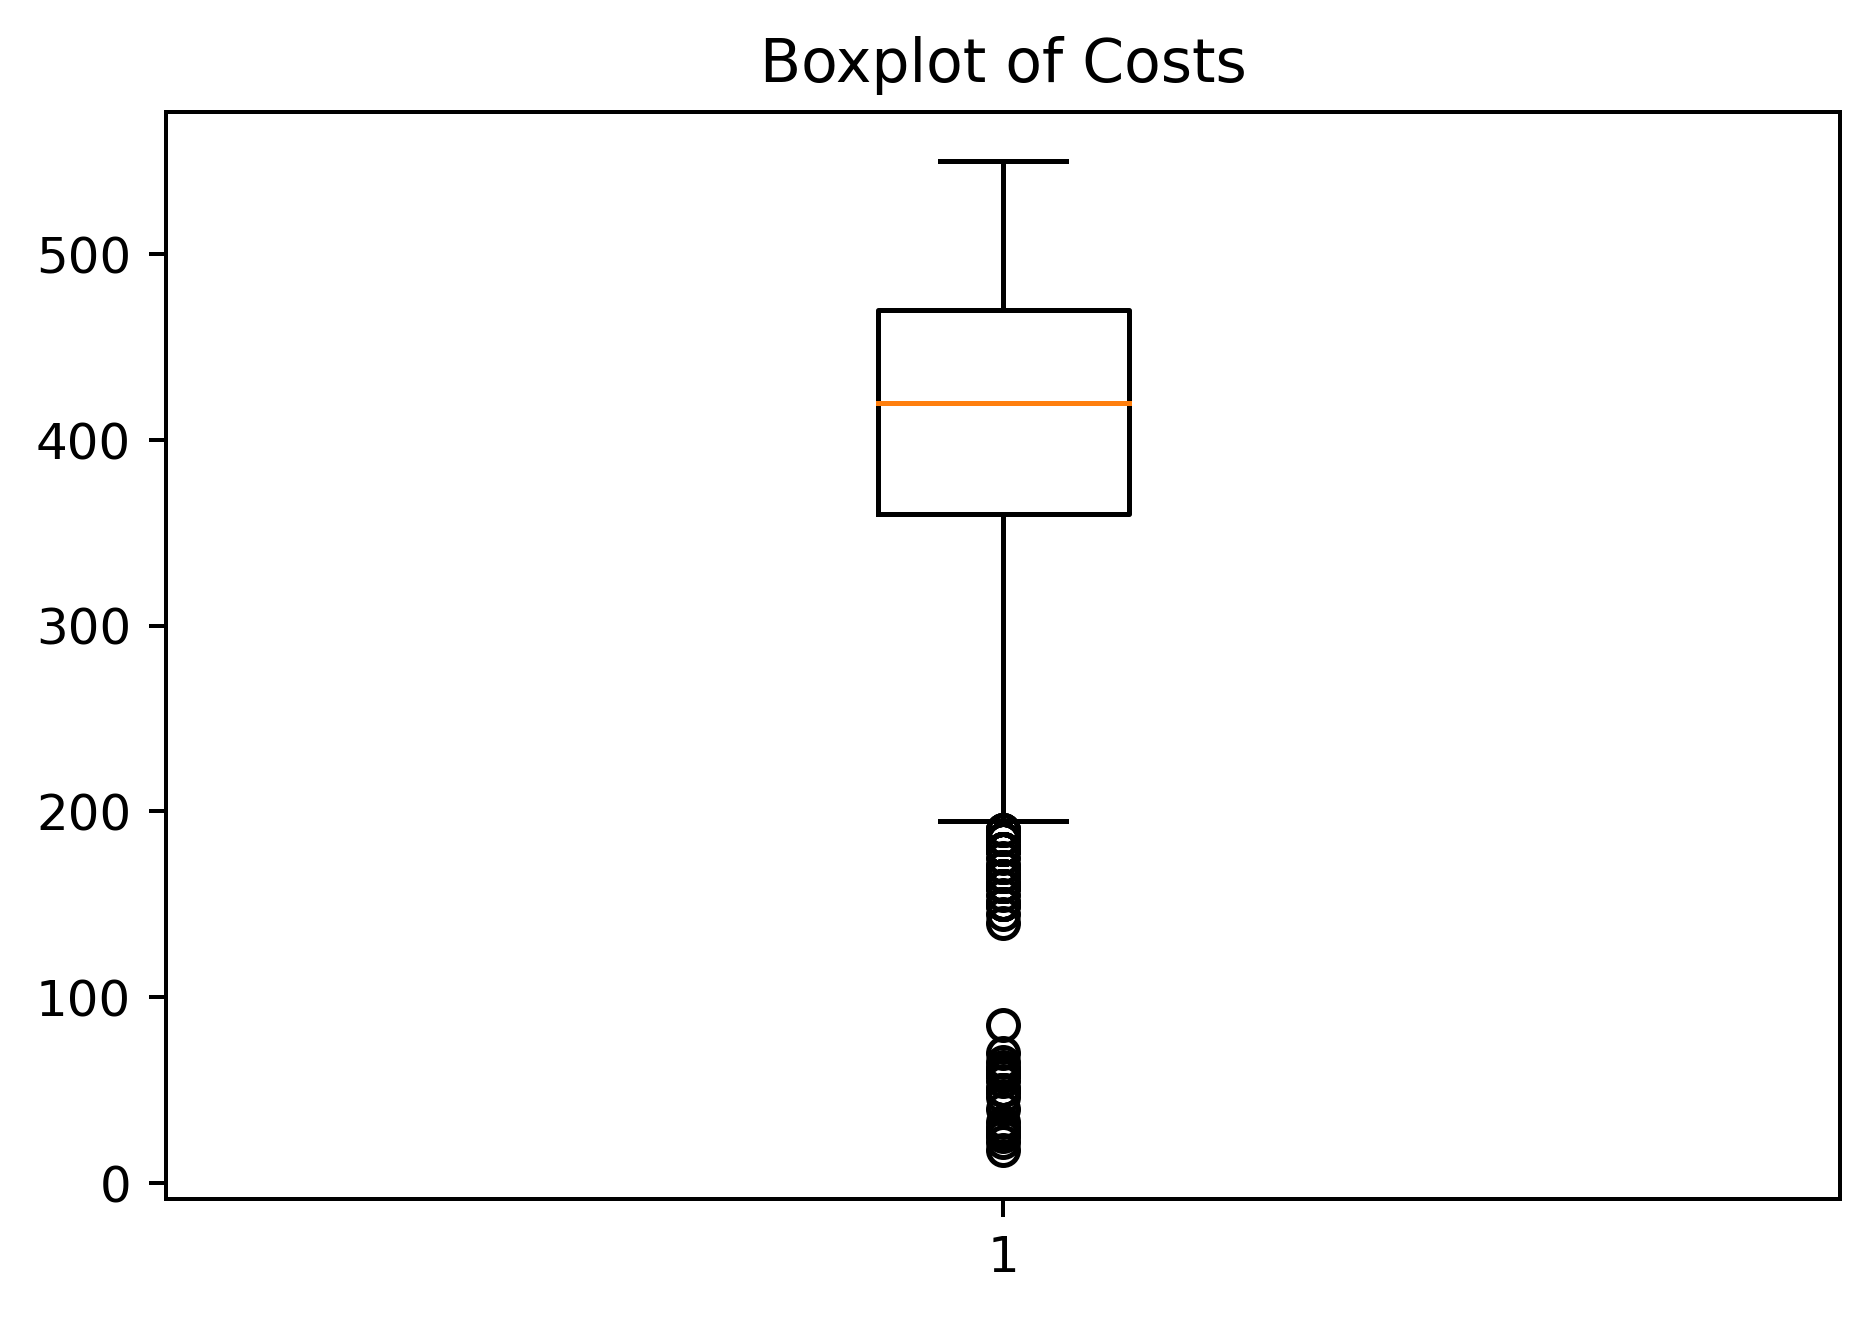

In [89]:
plt.boxplot(df_full['cost'])
plt.title('Boxplot of Costs')
plt.savefig(main_directory+'models/cost_boxplot.png')

#### From the 2 plots, we can see that there are a lot of outliers with low costs. They may be associated with the many storage units in listing.

### OLS Regression based on POI

In [24]:
def get_stats():
    df = df_full.drop(['coordinates', 'e-cigarette'], axis=1)
    results = ols(formula='cost ~ ' + " + ".join(list(df.columns)[:-1]), data=df).fit()
    #print(results.summary())
    #print(sm.stats.anova_lm(results))
    return results.summary(), sm.stats.anova_lm(results)

In [25]:
summ, anova = get_stats()

In [26]:
top_features = anova.sort_values('PR(>F)').head(20)

In [18]:
#summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cost   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     6.115
Date:                Sat, 08 Oct 2022   Prob (F-statistic):          6.39e-167
Time:                        14:37:59   Log-Likelihood:                -35964.
No. Observations:                5975   AIC:                         7.247e+04
Df Residuals:                    5703   BIC:                         7.429e+04
Df Model:                         271                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                490.8965      4.909     99.996      0.000     481.273     500.520
distance                   0.0002      0.000      1.174      0.240      -0.000       0.001
duration                  -0.0104      0.004     -2.354      0.019      -0.019      -0.002
pitch                      0.1488      0.053      2.795      0.005       0.044       0.253
water                      0.2675      0.163      1.642      0.101      -0.052       0.587
school                    -2.4709      0.524     -4.715      0.000      -3.498      -1.444
swimming_pool              0.0374      0.037      1.020      0.308      -0.035       0.109
parking                    0.0857      0.052      1.642      0.101      -0.017       0.188
social_facility            0.6089      1.039      0.586      0.558      -1.428       2.645
fuel                      -2.4067      1.030     -2.336      0.020      -4.426      -0.387
mall                      -1.9740      1.534     -1.287      0.198      -4.981       1.033
hardware                  -1.6837      2.607     -0.646      0.518      -6.794       3.427
police                    -0.1867      2.595     -0.072      0.943      -5.275       4.901
post_office               -0.4023      1.631     -0.247      0.805      -3.599       2.794
pharmacy                   2.0927      1.217      1.719      0.086      -0.294       4.479
beauty                     5.5008      1.298      4.237      0.000       2.956       8.046
dairy                      3.5636     15.134      0.235      0.814     -26.105      33.232
golf_course               -9.1434      2.466     -3.707      0.000     -13.978      -4.308
park                      -0.3499      0.106     -3.308      0.001      -0.557      -0.143
hospital                   1.7609      1.239      1.421      0.155      -0.668       4.190
sports_centre             -1.5794      0.876     -1.804      0.071      -3.296       0.137
community_centre          -0.7395      1.400     -0.528      0.597      -3.485       2.006
caravan_site              -1.3358      2.838     -0.471      0.638      -6.899       4.228
kindergarten              -0.8941      1.029     -0.869      0.385      -2.910       1.122
place_of_worship          -1.4700      0.659     -2.231      0.026      -2.762      -0.178
raceway                   -1.1797      2.369     -0.498      0.619      -5.825       3.465
restaurant                 0.2327      0.280      0.830      0.407      -0.317       0.783
tyres                     -3.1683      2.522     -1.257      0.209      -8.111       1.775
veterinary                 7.4326      2.492      2.982      0.003       2.547      12.318
building                   3.4564      2.315      1.493      0.136      -1.082       7.995
alcohol                    1.1730      1.184      0.991      0.322      -1.148  

In [49]:
#top_features.iloc[1:12,]

,df,sum_sq,mean_sq,F,PR(>F)
motel,1.0,1.146735e+06,1.146735e+06,110.560981,1.265279e-25
school,1.0,5.760066e+05,5.760066e+05,55.534953,1.055174e-13
supermarket,1.0,5.635985e+05,5.635985e+05,54.338638,1.928180e-13
beach,1.0,5.121318e+05,5.121318e+05,49.376544,2.359473e-12
pub,1.0,5.075629e+05,5.075629e+05,48.936034,2.947884e-12
restaurant,1.0,4.275929e+05,4.275929e+05,41.225830,1.465778e-10
pitch,1.0,4.227708e+05,4.227708e+05,40.760910,1.856272e-10
police,1.0,4.003858e+05,4.003858e+05,38.602690,5.562299e-10
post_office,1.0,3.940225e+05,3.940225e+05,37.989184,7.601178e-10
fire_station,1.0,3.595628e+05,3.595628e+05,34.666790,4.135630e-09


In [94]:
top_features.to_csv('../data/curated/top_features.csv')

The OLS model has a R^2 of 0.825, which is really good. However, it uses all the features, which loses out on generalisation.

# Liveability

In [60]:
sa2_rent = pd.read_csv(main_directory+'data/curated/SA2_rent_data.csv', index_col=0)
sa2_rent = sa2_rent[['coordinates', 'SA2 name']]
df_live = pd.concat([df_full, sa2_rent], join='inner', ignore_index=True, axis=1).drop(columns=274)
columns = chain.from_iterable([['coordinates'],['distance', 'duration'], ls, ['cost'], ['sa2_code']])
df_live.set_axis(columns, axis=1, inplace=True)
gb_live = df_live[['supermarket', 'pitch', 'cafe', 'sa2_code']].groupby('sa2_code').mean().round(2)
live_list = ['supermarket', 'pitch', 'cafe']

#for i in range(3):
#    print(gb_live.sort_values(by=live_list[i], ascending=False).head(10),'\n')

                               supermarket   pitch    cafe
sa2_code                                                  
Rutherglen                           26.00   98.00  190.00
Myrtleford                           24.00   49.00   22.00
Alfredton                            21.00   74.42  128.84
East Bendigo - Kennington            20.43  155.86   74.71
Seymour                              18.00  200.00   10.00
Orbost                               17.00   79.00   59.00
Research - North Warrandyte          17.00   42.00   57.00
Geelong West - Hamlyn Heights        16.27   83.36   64.82
Korumburra                           16.00   47.00   47.00
Yarram                               15.00  219.00   71.00 

                           supermarket   pitch   cafe
sa2_code                                             
Montrose                         12.50  265.50  70.50
Castlemaine                      11.25  264.50  65.50
Yarram                           15.00  219.00  71.00
Ballarat            

C:\Users\aranw\AppData\Local\Temp\ipykernel_24980\1200070024.py:5: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_live.set_axis(columns, axis=1, inplace=True)


### Modelling (reduced)

We now try and fit an elastic net regression model on the data.

#### Perform a grid search through values for alpha and penalty parameters of elastic net to find optimal values.

In [95]:
X, y = df_full.iloc[:,1:-1], df_full.iloc[:,-1]
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
# define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = arange(0, 1, 0.1)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=2)
# perform the search
results = search.fit(X, y)
# summarize
# print('MAE: %.3f' % results.best_score_)
# print('Config: %s' % results.best_params_)

/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.235e+07, tolerance: 3.157e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.226e+07, tolerance: 3.114e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solv

### Create the elastic net model with optimal parameters

In [96]:
x = df_full[ls]
y = df_full['cost']
# Scale the columns
scaler = StandardScaler()
df_scaled = scaler.fit_transform(x)
net = ElasticNet(random_state=0, alpha=0.1, l1_ratio=0)
results_cv = cross_validate(net, df_scaled, y, cv=10, n_jobs=2, scoring='r2')

In [ ]:
pd.DataFrame(results_cv).to_json(main_directory +'data/curated/CVresultsEnet.csv')

In [99]:
# results_cv['test_score']

We can see that the variance of the R^2 value across the validation runs is very high.

In [100]:
net.fit(df_scaled,y)

/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.487e+07, tolerance: 3.501e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.1, l1_ratio=0, random_state=0)

In [101]:
coefs = net.coef_
remove_list = []
for i in range(len(coefs)):
    if abs(coefs[i]) < 0.05:
        remove_list.append(ls[i])

In [102]:
# remove_list

In [103]:
len(remove_list)

5

In [104]:
columns = list(chain.from_iterable([['coordinates'], ['distance', 'duration'],ls]))

In [105]:
df_reduce = df_full[columns].drop(remove_list, axis=1)

In [106]:
df_unique = pd.DataFrame(df_reduce.nunique(), columns=['Counts'])

In [107]:
# df_unique[df_unique['Counts'] <= 5]

#### There are quite a lot of features with few unique values. Most of these could be noise to the data, and will need to be filtered out.

In [108]:
remove_list = list(df_unique[df_unique['Counts'] <= 5].index)

In [109]:
df_reduce = df_reduce.drop(remove_list, axis=1)

In [110]:
# df_reduce

In [111]:
# For further testing if required
#df_unique2 = pd.DataFrame(df_reduce.nunique(), columns=['Counts'])

In [112]:
df_reduce.to_csv(main_directory+'data/curated/reduced_POI_optimal_v2.csv')

In [113]:
df_reduce

,coordinates,distance,duration,water,park,school,pitch,parking,doityourself,playground,...,casino,blood_donation,estate_agent,raceway,bird_hide,peak,bus_station,cannon,ship,ice_rink
0,"[-37.5769948, 144.9288833]",219148.5,10568.7,10.0,59.0,6.0,22.0,38.0,1.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"[-37.7372796, 144.7821909]",292009.2,12243.3,8.0,40.0,10.0,93.0,83.0,0.0,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"[-37.8827602, 144.6497957]",292171.1,12257.9,10.0,48.0,4.0,46.0,32.0,0.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"[-37.8167974, 145.1876561]",211239.3,9285.7,14.0,118.0,12.0,80.0,182.0,2.0,58.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"[-37.8229957, 145.0242336]",210269.4,9193.0,1.0,57.0,18.0,295.0,212.0,2.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4926,"[-34.2311746, 142.172547]",6833.7,808.1,0.0,0.0,2.0,4.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4927,"[-34.2300429, 142.1609475]",85412.7,4312.4,0.0,0.0,2.0,4.0,9.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4928,"[-37.8802849, 147.8299957]",14737.3,1520.1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4929,"[-37.8791032, 147.8273685]",20090.3,1788.7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Final modelling (all relevant features)

### OLS model

In [29]:
# drop irrelevant columns
SA2_data.drop(columns = ['Median $ 2019','SA2 CODE'], inplace = True)

In [30]:
# rename variable so it can be joined
SA2_data.rename(columns = {'mean price':'mean_price', 'Mean $ 2019': 'Mean_income_2019', '2021 crime rate': 'crime_rate_2021'}, inplace = True)

In [31]:
# segregate all features columns
features_names = list(SA2_data.iloc[[],2:].columns)

In [32]:
# features_names

In [34]:
# generate a simple linear model
OLS_SA2 = ols(
   formula = "mean_price ~ " + ' + '.join(features_names), data = SA2_data
).fit()

In [35]:
# OLS_SA2.summary() # summarise model fit

In [36]:
# perform anova to assess variables 
anova_table_2 = sm.stats.anova_lm(OLS_SA2)

In [37]:
# anova_table_2

only mean income seems to be significant for forecasting population

### Negative Binomial

In [301]:
# generate a NB model
NB_SA2 = glm(
   formula = "mean_price ~ " + ' + '.join(features_names), data = SA2_data,
family = families.NegativeBinomial()
).fit()

In [302]:
# NB_SA2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             mean_price   No. Observations:                  314
Model:                            GLM   Df Residuals:                      305
Model Family:        NegativeBinomial   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2255.3
Date:                Sun, 02 Oct 2022   Deviance:                       12.372
Time:                        18:11:40   Pearson chi2:                     14.6
No. Iterations:                     6   Pseudo R-squ. (CS):            0.02198
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         5.6554      0.321     17.643      0.000       5.027       6.284
pop_2021                       1.489e-05    9.1e-05      0.164      0.870      -0.000       0.000
Area                          -2.678e-05   5.19e-05     -0.516      0.606      -0.000    7.49e-05
Children_population            -1.88e-05   9.34e-05     -0.201      0.841      -0.000       0.000
Early_Working_age_population  -2.379e-05      0.000     -0.164      0.870      -0.000       0.000
Prime_Working_age_population  -7.983e-06   6.74e-05     -0.118      0.906      -0.000       0.000
Mature_Working_age_population  9.321e-05      0.000      0.385      0.700      -0.000       0.001
Elderly_population            -1.287e-05      0.000     -0.114      0.909      -0.000       0.000
crime_rate_2021                  -0.2294      2.525     -0.091      0.928      -5.179       4.720
Mean_income_2019               8.498e-06   3.62e-06      2.349      0.019    1.41e-06    1.56e-05
=================================================================================================
"""

it seems that a OLS is more appropriate with only income as the only predictor

### testing

In this section we will be testing OLS and NB models through cross validation

In [303]:
# reset index
SA2_data.reset_index(inplace = True)

In [59]:
# list to store error rates
OLS_error = []
NB_error = []

# we will perform a one part out cross validation 
for i in range(len(SA2_data)):
    # take out one part for testing
    test = SA2_data.iloc[[i],]
    # rest for training
    train = SA2_data[SA2_data.index !=i]
    
    # fit OLS model 
    OLS_income = ols(
       formula = "np.log(mean_price) ~ Mean_income_2019", data = train,
    family = families.NegativeBinomial()
        ).fit()
    # fit NB model
    NB_income =glm(
   formula = "np.log(mean_price) ~ Mean_income_2019", data = train,
    family = families.NegativeBinomial()
    ).fit()
    
    # output accuracy scores into pd frame '
    OLS_error.append(np.exp(float(OLS_income.predict(test))) - test['mean_price'])
    NB_error.append(np.exp(float(NB_income.predict(test))) - test['mean_price'])




/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
/Users/luc

In [60]:
# create pandas frame to store results
Results_CV = pd.DataFrame()

# write results error in

Results_CV['OLS error'] = OLS_error
Results_CV['NB error'] = NB_error

In [61]:
# change all to absolute values
Results_CV['OLS error'] = abs(Results_CV['OLS error'])
Results_CV['NB error'] = abs(Results_CV['NB error'])

In [62]:
# examine the errors -OLS
# print('median of OLS errors is', Results_CV['OLS error'].median())
# print('sd of OLS errors is', Results_CV['OLS error'].std())

In [64]:
# examine NB errors
# print('median of NB errors is', Results_CV['NB error'].median())
# print('sd of NB errors is', Results_CV['NB error'].std())

the OLS model seems to be a better fit in this case, so we will use this for our forecasts

## Future data

In [38]:
# read in future data for income
future_income_data=pd.read_csv(main_directory+'data/curated/forecast_income_SA2.csv')

In [39]:
# future_income_data.sort_values(by = ['SA2_NAME'])

In [40]:
# SA2_data

In [326]:
SA2_data.reset_index(inplace = True)

In [327]:
# new df with only relevant data
SA2_data_relevant = pd.DataFrame()
SA2_data_relevant['SA2'] = SA2_data['SA2 name']
SA2_data_relevant['mean_price']=SA2_data['mean_price']

In [328]:
# merge df
future_income_data=future_income_data.merge(SA2_data_relevant, how = 'inner', left_on = 'SA2_NAME', right_on = 'SA2')

In [329]:
# future_income_data

,Unnamed: 0,SA2_NAME,2020,2021,2022,2023,2024,2025,SA2,mean_price
0,0,Alfredton,81603.0,85174.8,88902.9,92794.2,96855.8,101095.2,Alfredton,423.421053
1,1,Ballarat,67662.9,70214.6,72862.5,75610.2,78461.6,81420.5,Ballarat,398.928571
2,4,Buninyong,65636.4,67665.6,69757.6,71914.3,74137.6,76429.7,Buninyong,410.000000
3,5,Delacombe,87498.9,90983.2,94606.2,98373.6,102290.9,106364.3,Delacombe,440.000000
4,7,Wendouree - Miners Rest,36547.4,39749.9,43232.9,47021.1,51141.3,55622.5,Wendouree - Miners Rest,357.916667
...,...,...,...,...,...,...,...,...,...,...
309,455,Corangamite - North,104078.6,108804.4,113744.8,118909.5,124308.8,129953.2,Corangamite - North,340.000000
310,457,Otway,49889.2,51292.7,52735.8,54219.5,55744.9,57313.2,Otway,395.000000
311,458,Moyne - East,86502.6,90012.0,93663.8,97463.8,101417.9,105532.5,Moyne - East,300.000000
312,460,Warrnambool - North,56678.5,61222.3,66130.4,71431.9,77158.4,83344.0,Warrnambool - North,367.142857


In [330]:
# future_income_data

,Unnamed: 0,SA2_NAME,2020,2021,2022,2023,2024,2025,SA2,mean_price
0,0,Alfredton,81603.0,85174.8,88902.9,92794.2,96855.8,101095.2,Alfredton,423.421053
1,1,Ballarat,67662.9,70214.6,72862.5,75610.2,78461.6,81420.5,Ballarat,398.928571
2,4,Buninyong,65636.4,67665.6,69757.6,71914.3,74137.6,76429.7,Buninyong,410.000000
3,5,Delacombe,87498.9,90983.2,94606.2,98373.6,102290.9,106364.3,Delacombe,440.000000
4,7,Wendouree - Miners Rest,36547.4,39749.9,43232.9,47021.1,51141.3,55622.5,Wendouree - Miners Rest,357.916667
...,...,...,...,...,...,...,...,...,...,...
309,455,Corangamite - North,104078.6,108804.4,113744.8,118909.5,124308.8,129953.2,Corangamite - North,340.000000
310,457,Otway,49889.2,51292.7,52735.8,54219.5,55744.9,57313.2,Otway,395.000000
311,458,Moyne - East,86502.6,90012.0,93663.8,97463.8,101417.9,105532.5,Moyne - East,300.000000
312,460,Warrnambool - North,56678.5,61222.3,66130.4,71431.9,77158.4,83344.0,Warrnambool - North,367.142857


In [331]:
# future_income_data.dropna() # are there anymore NA values

,Unnamed: 0,SA2_NAME,2020,2021,2022,2023,2024,2025,SA2,mean_price
0,0,Alfredton,81603.0,85174.8,88902.9,92794.2,96855.8,101095.2,Alfredton,423.421053
1,1,Ballarat,67662.9,70214.6,72862.5,75610.2,78461.6,81420.5,Ballarat,398.928571
2,4,Buninyong,65636.4,67665.6,69757.6,71914.3,74137.6,76429.7,Buninyong,410.000000
3,5,Delacombe,87498.9,90983.2,94606.2,98373.6,102290.9,106364.3,Delacombe,440.000000
4,7,Wendouree - Miners Rest,36547.4,39749.9,43232.9,47021.1,51141.3,55622.5,Wendouree - Miners Rest,357.916667
...,...,...,...,...,...,...,...,...,...,...
309,455,Corangamite - North,104078.6,108804.4,113744.8,118909.5,124308.8,129953.2,Corangamite - North,340.000000
310,457,Otway,49889.2,51292.7,52735.8,54219.5,55744.9,57313.2,Otway,395.000000
311,458,Moyne - East,86502.6,90012.0,93663.8,97463.8,101417.9,105532.5,Moyne - East,300.000000
312,460,Warrnambool - North,56678.5,61222.3,66130.4,71431.9,77158.4,83344.0,Warrnambool - North,367.142857


In [332]:
# rename columns 
for i in range(2020,2026): 
    future_income_data=future_income_data.rename(columns = {str(i): 'Mean_income_' + str(i)})

In [334]:
# let's fit the model with the 2022 data
OLS_SA2_2022 = ols(
   formula = "mean_price ~ Mean_income_2021", data = future_income_data
).fit()

In [335]:
# OLS_SA2_2022.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             mean_price   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     4.785
Date:                Sun, 02 Oct 2022   Prob (F-statistic):             0.0295
Time:                        18:15:33   Log-Likelihood:                -1973.1
No. Observations:                 314   AIC:                             3950.
Df Residuals:                     312   BIC:                             3958.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          429.0057     28.468     15.070      0.000     372.992     485.019
Mean_income_2021     0.0009      0.000      2.187      0.029    9.12e-05       0.002
==============================================================================
Omnibus:                      106.322   Durbin-Watson:                   1.167
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              319.970
Skew:                           1.531   Prob(JB):                     3.31e-70
Kurtosis:                       6.884   Cond. No.                     2.66e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.66e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R squared value is much lower when using supposedly current income data, this suggests that perhaps rental prices are adjusted at a slower rate than income ie. average income is refleceted years later in the rental prices, hence we will keep the model as it is where income 3 years ago is used to foreecast the most current years' prices of rent per SA2

## forecasting

In [336]:
SA2_data.rename(columns = {'Mean_income_2019': 'Mean_income'}, inplace = True) # rename to fit general model

In [337]:
# SA2_data

,index,SA2 name,mean_price,median price,pop_2021,Area,Children_population,Early_Working_age_population,Prime_Working_age_population,Mature_Working_age_population,Elderly_population,crime_rate_2021,Mean_income
0,0,Abbotsford,572.679045,575.0,9262.0,1.7,759.0,905.0,6450.0,578.0,9832.0,0.118272,78181.0
1,1,Airport West,409.000000,400.0,8237.0,3.7,1384.0,762.0,4102.0,797.0,9429.0,0.049673,65204.0
2,2,Albert Park,700.882353,535.0,16023.0,4.7,2165.0,1470.0,8541.0,1731.0,18139.0,0.098302,120412.0
3,3,Alexandra,350.000000,350.0,6768.0,2119.0,910.0,531.0,2601.0,1258.0,8236.0,0.043809,48414.0
4,4,Alfredton,423.421053,420.0,16823.0,52.7,4075.0,2391.0,7550.0,1375.0,18255.0,0.063340,63668.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,309,Yarram,327.500000,327.5,5556.0,1931.9,777.0,470.0,2122.0,1098.0,6645.0,0.070800,48524.0
310,310,Yarraville,560.571429,540.0,15653.0,5.6,3024.0,1439.0,8874.0,1172.0,16797.0,0.081576,83130.0
311,311,Yarrawonga,451.666667,495.0,8585.0,94.7,1364.0,752.0,2986.0,1367.0,10701.0,0.053705,49703.0
312,312,Yarriambiack,307.500000,307.5,6454.0,7139.6,1015.0,586.0,2412.0,1105.0,7790.0,0.075221,52472.0


In [338]:
# create final model
OLS_final = ols(formula = 'mean_price ~ Mean_income', data = SA2_data).fit()

In [339]:
# OLS_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             mean_price   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     135.6
Date:                Sun, 02 Oct 2022   Prob (F-statistic):           2.90e-26
Time:                        18:15:58   Log-Likelihood:                -1918.8
No. Observations:                 314   AIC:                             3842.
Df Residuals:                     312   BIC:                             3849.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     211.6077     24.624      8.593      0.000     163.157     260.059
Mean_income     0.0044      0.000     11.644      0.000       0.004       0.005
==============================================================================
Omnibus:                      186.605   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1576.060
Skew:                           2.357   Prob(JB):                         0.00
Kurtosis:                      12.911   Cond. No.                     2.63e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.63e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [340]:
# df to store predictions
Predictions = pd.DataFrame()
Predictions['SA2'] = future_income_data['SA2_NAME']
# predict for the next three years; iterative
for i in range(2023,2026): 
    df = pd.DataFrame()
    df['Mean_income'] = future_income_data['Mean_income_' +str(i)]
    Predictions[str(i)] = OLS_final.predict(df).astype(float)
    

    
    


In [341]:
#1. make new df to reflect current mean prices per SA2
current_rent = pd.DataFrame()
current_rent['SA2']=SA2_data['SA2 name']
current_rent['2022'] = SA2_data['mean_price']

In [342]:
# join current with future to allow comparisons
Predictions=pd.merge(Predictions, current_rent, left_on = ['SA2'], right_on = ['SA2'])

In [343]:
# get rate of change per year
for i in range(2022, 2025): 
    Predictions['Change from ' + str(i)+' to '+ str(i+1)] =  Predictions[str(i+1)] -  Predictions[str(i)]

In [344]:
# get total change
Predictions['total_change'] = (Predictions['Change from 2022 to 2023'] +Predictions['Change from 2023 to 2024']
                               +Predictions['Change from 2024 to 2025'])

In [345]:
# get average change
Predictions['average_change'] = Predictions['total_change']/3

In [349]:
Predictions.sort_values(by = ['average_change'], ascending = False,inplace = True) # sort by growth rate average

In [362]:
# get top ten suburbs
top_ten = Predictions.iloc[:10,]

In [364]:
# top_ten

,SA2,2023,2024,2025,2022,Change from 2022 to 2023,Change from 2023 to 2024,Change from 2024 to 2025,total_change,average_change
261,Melton West,853.669805,868.643577,883.967085,341.500000,512.169805,14.973772,15.323508,542.467085,180.822362
34,Kilmore - Broadford,864.398395,878.181843,892.256231,395.625000,468.773395,13.783449,14.074388,496.631231,165.543744
309,Corangamite - North,729.502914,753.018879,777.602346,340.000000,389.502914,23.515965,24.583467,437.602346,145.867449
301,Moira,669.936221,727.073487,791.333095,400.000000,269.936221,57.137266,64.259607,391.333095,130.444365
221,Dandenong North,731.970233,745.612132,759.612043,379.642857,352.327376,13.641899,13.999911,379.969186,126.656395
276,Frankston,731.286875,739.472798,747.787641,375.833333,355.453542,8.185923,8.314842,371.954307,123.984769
311,Moyne - East,636.098894,653.320474,671.241091,300.000000,336.098894,17.221580,17.920617,371.241091,123.747030
286,Point Nepean,1159.115591,1193.153701,1228.414800,876.923077,282.192514,34.038110,35.261099,351.491723,117.163908
130,Preston - East,758.900810,775.431628,792.461572,461.315789,297.585021,16.530818,17.029944,331.145782,110.381927
111,Carnegie,703.753950,716.325298,729.218073,416.200000,287.553950,12.571348,12.892775,313.018073,104.339358


In [365]:
# plot income change for top ten suburbs 
top_ten_income = future_income_data[future_income_data['SA2_NAME'].isin(list(top_ten['SA2']))]

In [380]:
# top_ten_income

,Unnamed: 0,SA2_NAME,Mean_income_2020,Mean_income_2021,Mean_income_2022,Mean_income_2023,Mean_income_2024,Mean_income_2025,SA2,mean_price
34,55,Kilmore - Broadford,140774.9,143747.3,146782.5,149881.7,153046.4,156277.9,Kilmore - Broadford,395.625000
111,175,Carnegie,104762.4,107438.5,110182.9,112997.5,115883.9,118844.1,Carnegie,416.200000
130,209,Preston - East,114927.6,118398.9,121975.1,125659.3,129454.8,133364.9,Preston - East,461.315789
221,333,Dandenong North,110551.2,113449.5,116423.8,119476.0,122608.2,125822.6,Dandenong North,379.642857
261,379,Melton West,137567.2,140775.5,144058.7,147418.4,150856.4,154374.7,Melton West,341.500000
276,398,Frankston,113853.6,115647.0,117468.7,119319.1,121198.6,123107.7,Frankston,375.833333
286,410,Point Nepean,195692.3,202722.3,210005.0,217549.2,225364.4,233460.4,Point Nepean,876.923077
301,440,Moira,73974.8,83196.7,93568.3,105232.9,118351.7,133105.8,Moira,400.000000
309,455,Corangamite - North,104078.6,108804.4,113744.8,118909.5,124308.8,129953.2,Corangamite - North,340.000000
311,458,Moyne - East,86502.6,90012.0,93663.8,97463.8,101417.9,105532.5,Moyne - East,300.000000


<AxesSubplot:>

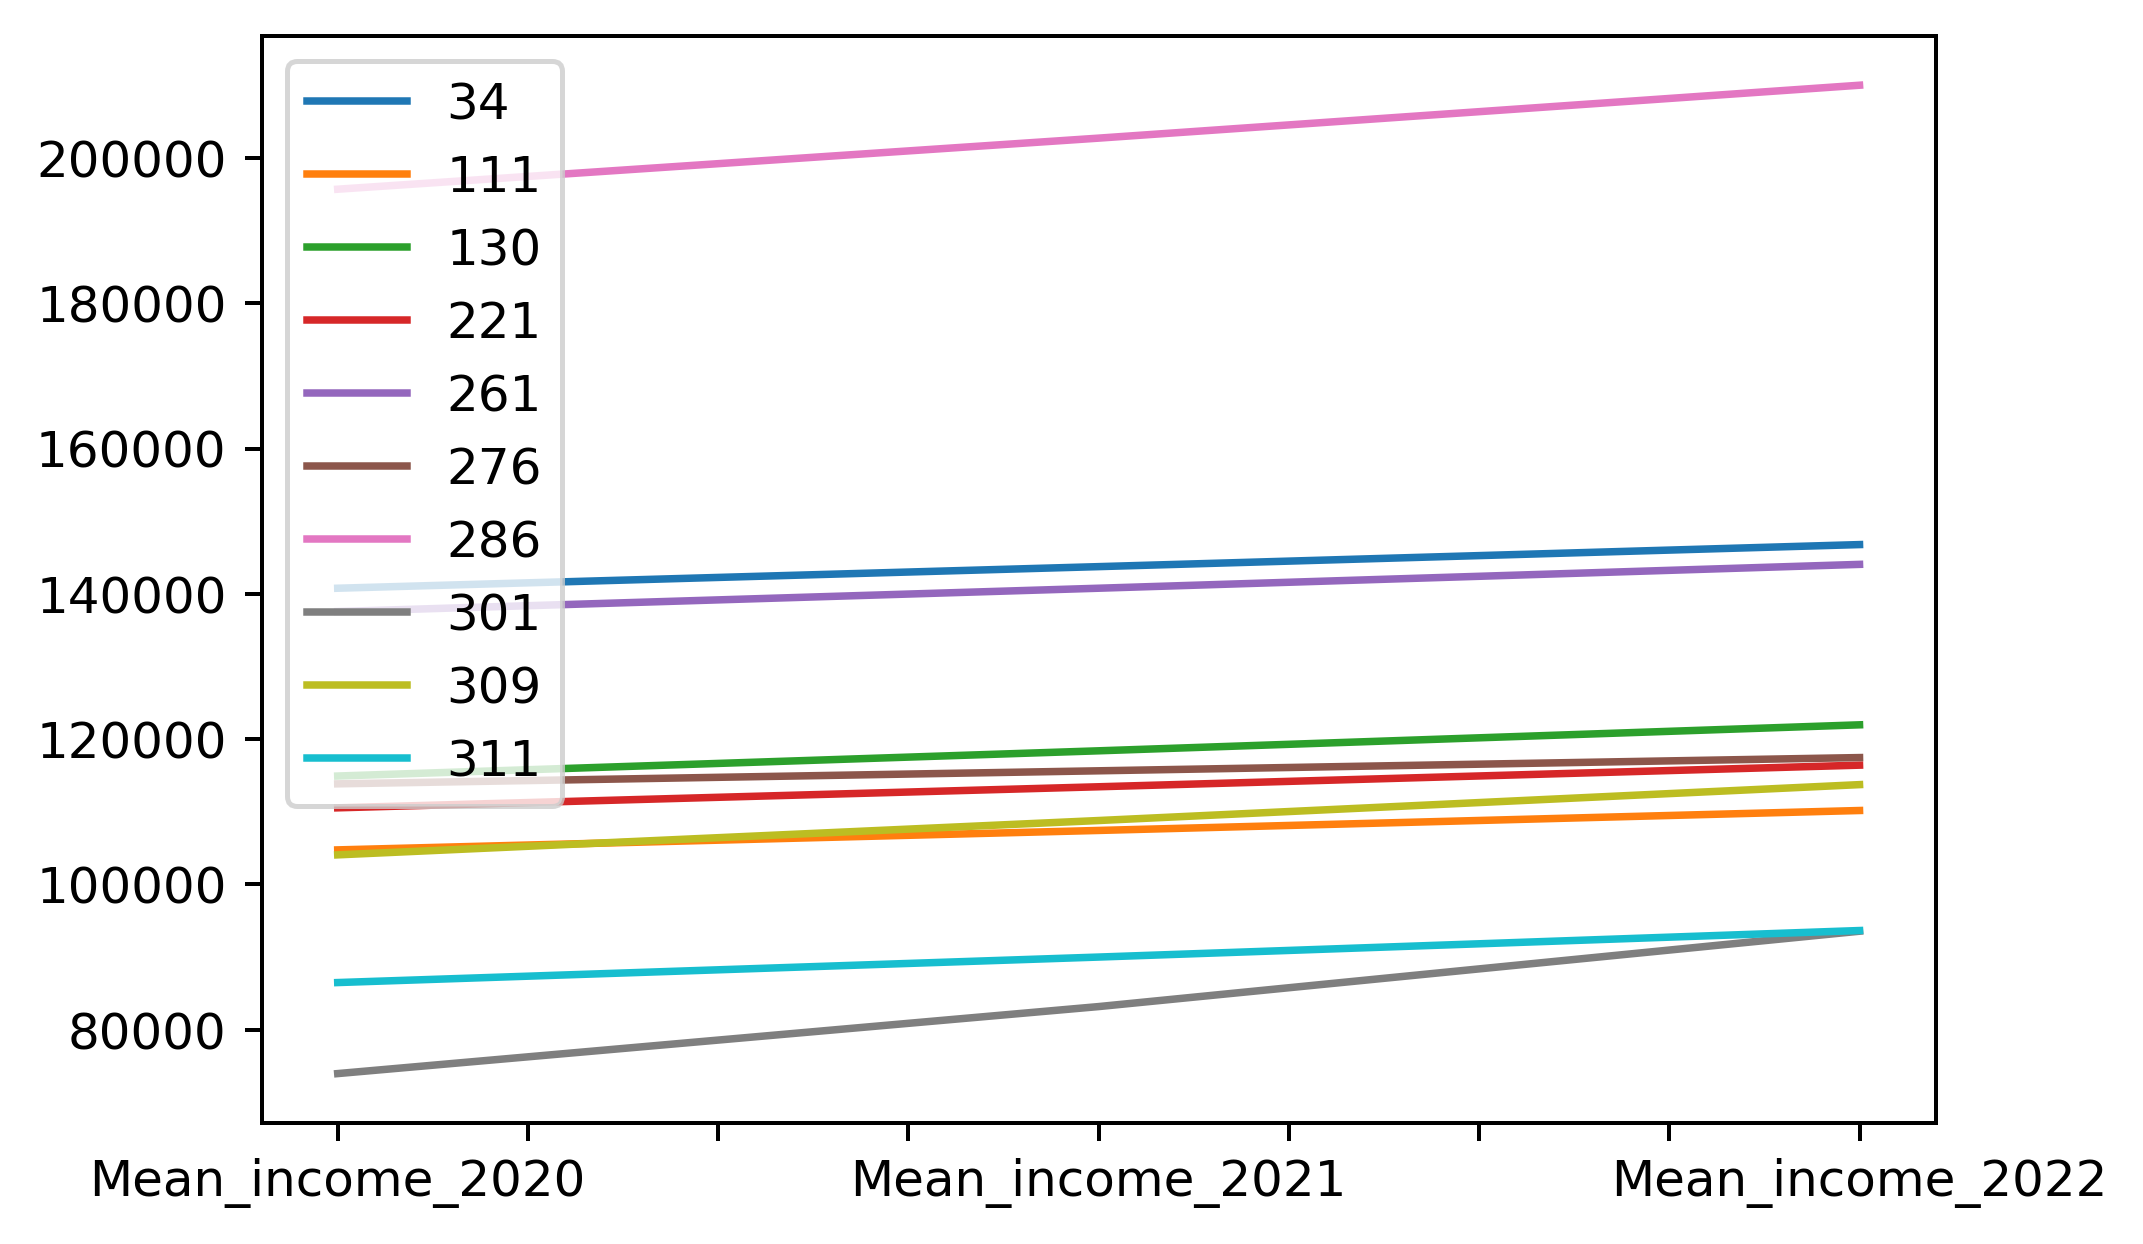

In [382]:
# top_ten_income.T.iloc[2:5,].plot()

In [391]:
# sort values to be consistent -> join 2019 data to income data
SA2_data.sort_values(by = ['SA2 name'], inplace = True)
future_income_data.sort_values(by = ['SA2_NAME'], inplace = True)

In [393]:
future_income_data['Mean_income_2019'] = SA2_data['Mean_income']

In [395]:
# get change in income each year
for i in range(2019, 2025): 
    future_income_data['Change from ' + str(i)+' to '+ str(i+1)] = future_income_data['Mean_income_'+ str(i+1)] -  future_income_data['Mean_income_'+ str(i)]


In [396]:
# future_income_data

,Unnamed: 0,SA2_NAME,Mean_income_2020,Mean_income_2021,Mean_income_2022,Mean_income_2023,Mean_income_2024,Mean_income_2025,SA2,mean_price,Change from 2020 to 2021,Change from 2021 to 2022,Change from 2022 to 2023,Change from 2023 to 2024,Change from 2024 to 2025,Mean_income_2019,Change from 2019 to 2020
88,138,Abbotsford,62343.3,64161.1,66031.9,67957.3,69938.8,71978.0,Abbotsford,572.679045,1817.8,1870.8,1925.4,1981.5,2039.2,44333.0,18010.3
147,234,Airport West,58672.9,60259.5,61889.1,63562.7,65281.6,67046.9,Airport West,409.000000,1586.6,1629.6,1673.6,1718.9,1765.3,92805.0,-34132.1
79,127,Albert Park,52024.4,53296.2,54599.1,55933.8,57301.1,58701.9,Albert Park,700.882353,1271.8,1302.9,1334.7,1367.3,1400.8,67833.0,-15808.6
33,53,Alexandra,54380.0,55906.6,57476.1,59089.7,60748.6,62454.1,Alexandra,350.000000,1526.6,1569.5,1613.6,1658.9,1705.5,66473.0,-12093.0
0,0,Alfredton,81603.0,85174.8,88902.9,92794.2,96855.8,101095.2,Alfredton,423.421053,3571.8,3728.1,3891.3,4061.6,4239.4,78181.0,3422.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,103,Yarram,48105.0,48922.6,49754.1,50599.8,51459.8,52334.5,Yarram,327.500000,817.6,831.5,845.7,860.0,874.7,63008.0,-14903.0
257,374,Yarraville,62425.9,64439.8,66518.7,68664.6,70879.7,73166.3,Yarraville,560.571429,2013.9,2078.9,2145.9,2215.1,2286.6,49211.0,13214.9
303,442,Yarrawonga,70014.9,71448.5,72911.5,74404.4,75928.0,77482.7,Yarrawonga,451.666667,1433.6,1463.0,1492.9,1523.6,1554.7,94350.0,-24335.1
293,421,Yarriambiack,69194.4,71309.5,73489.3,75735.7,78050.8,80436.6,Yarriambiack,307.500000,2115.1,2179.8,2246.4,2315.1,2385.8,71001.0,-1806.6


In [397]:
# predictions to csv
Predictions.to_csv(main_directory +'data/curated/predictions_in_order.csv')